Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation
from google.colab import drive

In [2]:
## mount the google drive
drive.mount('/content/drive')



Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melanoma detection assignment/Dataset/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Melanoma detection assignment/Dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',  # Labels inferred from subdirectory names
    label_mode='int',   # Integer labels for multi-class classification
    image_size=(img_height, img_width),  # Resize images to 180x180
    batch_size=batch_size,        # Batch size of 32
    validation_split=0.2,  # Use 20% of data for validation
    subset="training",    # This is the training subset
    seed=123              # Seed for reproducibility
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",  # This is the validation subset
    seed=123
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

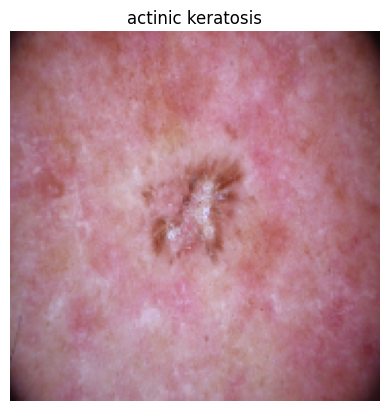

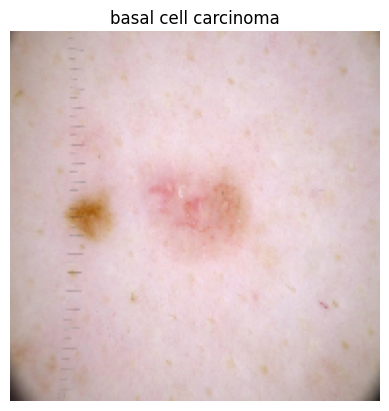

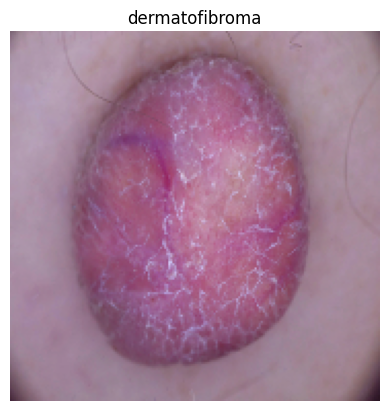

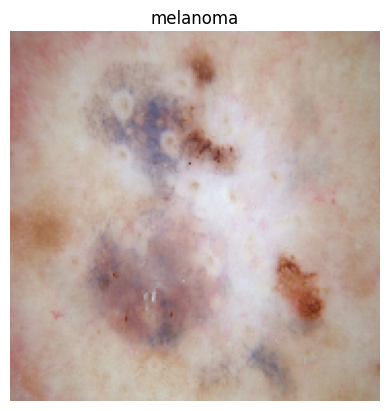

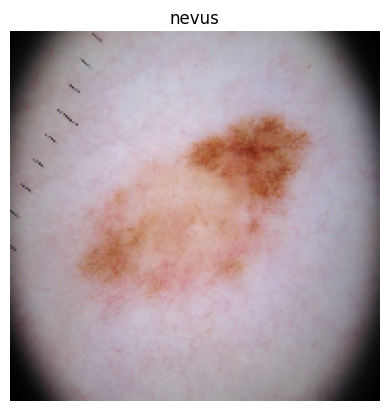

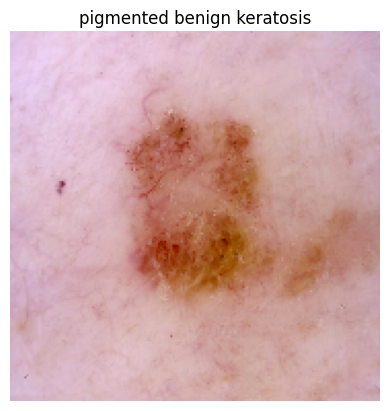

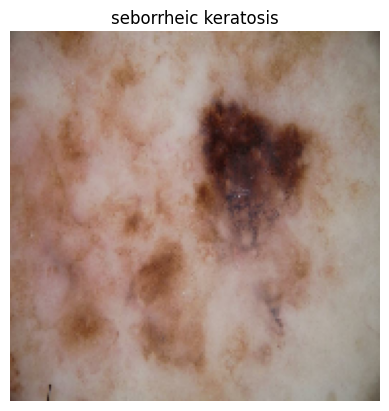

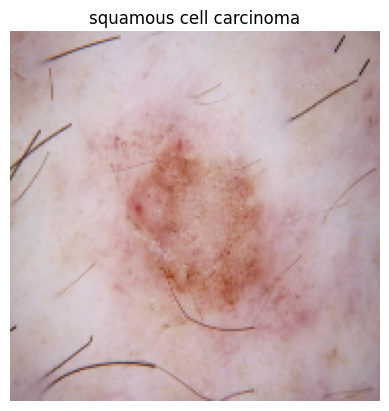

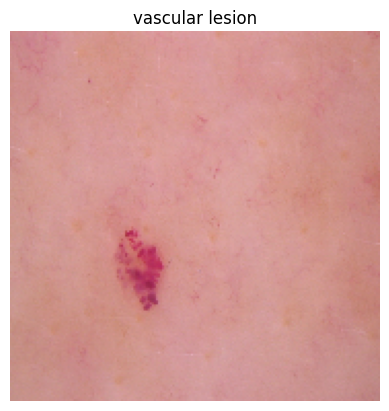

In [9]:
import matplotlib.pyplot as plt

# Loop through each class
for i in range(len(class_names)):
    # Filter the dataset for the current class
    filtered_dataset = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))

    # Take one image from the filtered dataset
    # filtered_dataset.take(1) returns a dataset obj (containing a tuple of images), but the iterator is smart enough
    # to unpack it into a tuple
    for image, label in filtered_dataset.take(1):
        # Display the image
        plt.figure()
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.title(class_names[label.numpy()[0]])
        plt.axis("off")
        plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# we do shuffling so that we can improve model generalization and prevent biases:
# 1. prevent overfitting, 2. reduce bias, 3. Improve generalization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [11]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense
model = models.Sequential()

# Add the normalization layer as the first layer
model.add(Rescaling(1./255, input_shape=(img_height, img_height, 3)))  # Normalize pixel values to [0, 1]
# Benefits of Normalization:

# Improved Model Performance: Normalizing pixel values helps your model converge faster and potentially achieve better accuracy.
# Preventing Vanishing/Exploding Gradients: It can prevent issues related to vanishing or exploding gradients during training.
# Consistency: It ensures that all input features are on a similar scale, which is beneficial for many machine learning algorithms.
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_height,img_height,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(64,activation='relu'))

model.add(Dense(len(class_names),activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 215168)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      13,770,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,864,649 (52.89 MB)

 Trainable params: 13,864,649 (52.89 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 795ms/step - accuracy: 0.2038 - loss: 2.2593 - val_accuracy: 0.3557 - val_loss: 1.8254
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3716 - loss: 1.7737 - val_accuracy: 0.4765 - val_loss: 1.5338
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4461 - loss: 1.5709 - val_accuracy: 0.4743 - val_loss: 1.5341
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5015 - loss: 1.4692 - val_accuracy: 0.5034 - val_loss: 1.4506
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5173 - loss: 1.3946 - val_accuracy: 0.4966 - val_loss: 1.4842
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5719 - loss: 1.2412 - val_accuracy: 0.5123 - val_loss: 1.4775
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5963 - loss: 1.1540 - val_accuracy: 0.4743 - val_loss: 1.5295
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6098 - loss: 1.0865 - val_accuracy: 0.5078 -

### Visualizing training results

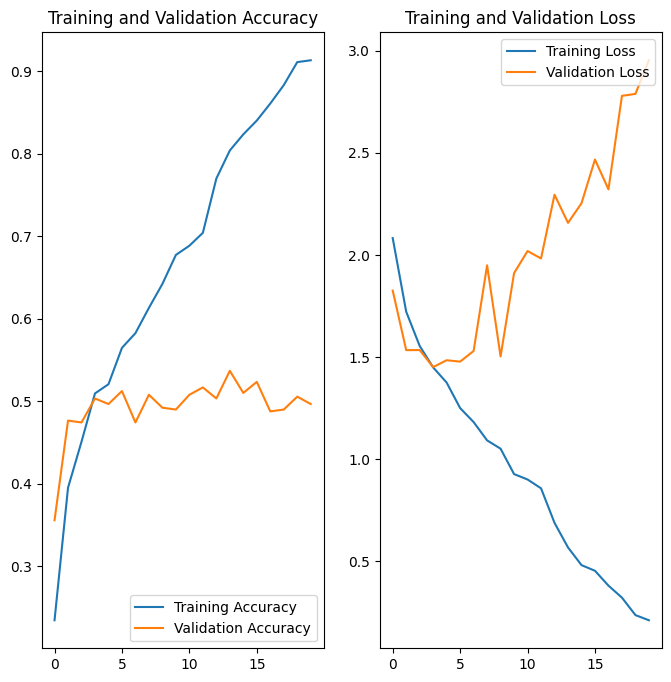

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after the model fit

Training Accuracy and Validation Accuracy:

- The training accuracy increases steadily and reaches approximately 0.9 by the end of training.
- The validation accuracy plateaus around 0.5 after a few epochs, showing little improvement despite further training.

Training Loss and Validation Loss:
- The training loss decreases consistently from ~2 to ~0.5, indicating the model is fitting the training data well.
- The validation loss decreases initially but starts increasing after around epoch 5, rising to ~2.5 by the end of training. This divergence between training and validation loss is a clear sign of overfitting.

### Create a model using augmentation to fix the problem of overfitting

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

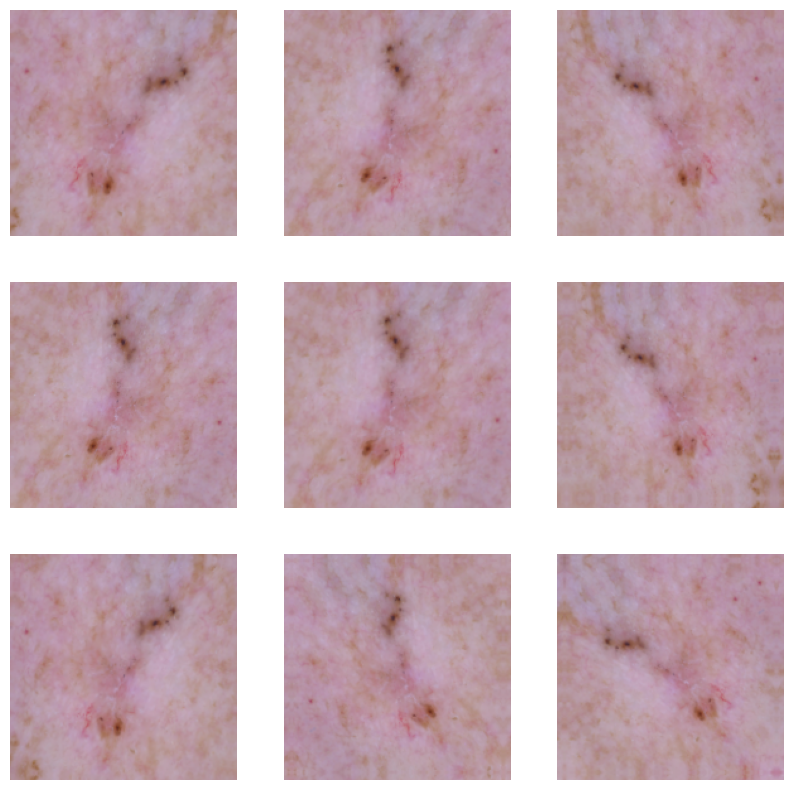

In [17]:
# Get a single image from the training dataset
for images, labels in train_ds.take(1):
    image = images[0]
    break  # Exit the loop after getting one image

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(image, 0))  # Augment the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

### Create the model, compile and train the model


In [18]:
from tensorflow.keras.layers import Dropout

model = models.Sequential()
# The augmented images are not permanently stored or added to your original dataset.
# They are generated on the fly during training and discarded after each batch is processed.
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_height, 3)))
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_height,img_height,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(64,activation='relu'))

# Dropout is most commonly used after Dense (fully connected) layers in CNNs,
# particularly those towards the end of the network.
# This is because Dense layers are more prone to overfitting due to their high number of parameters
# Add a Dropout layer with a dropout rate of 0.2
# (50% of neurons will be dropped out during training)
model.add(Dropout(0.5))

model.add(Dense(len(class_names),activation='softmax'))




### Compiling the model

In [19]:
# Compile the model (you might want to experiment with different optimizers)
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 215168)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      13,770,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,864,649 (52.89 MB)

 Trainable params: 13,864,649 (52.89 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.1888 - loss: 2.4274 - val_accuracy: 0.2752 - val_loss: 1.9528
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2820 - loss: 1.9575 - val_accuracy: 0.2774 - val_loss: 1.9708
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2660 - loss: 1.9391 - val_accuracy: 0.3736 - val_loss: 1.7991
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.3218 - loss: 1.8650 - val_accuracy: 0.4385 - val_loss: 1.6618
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3757 - loss: 1.7588 - val_accuracy: 0.3893 - val_loss: 1.6728
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3634 - loss: 1.7608 - val_accuracy: 0.4206 - val_loss: 1.6090
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3868 - loss: 1.7019 - val_accuracy: 0.4855 - val_loss: 1.5392
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4086 - loss: 1.6497 - val_accuracy: 0.4832 - v

### Visualizing the results

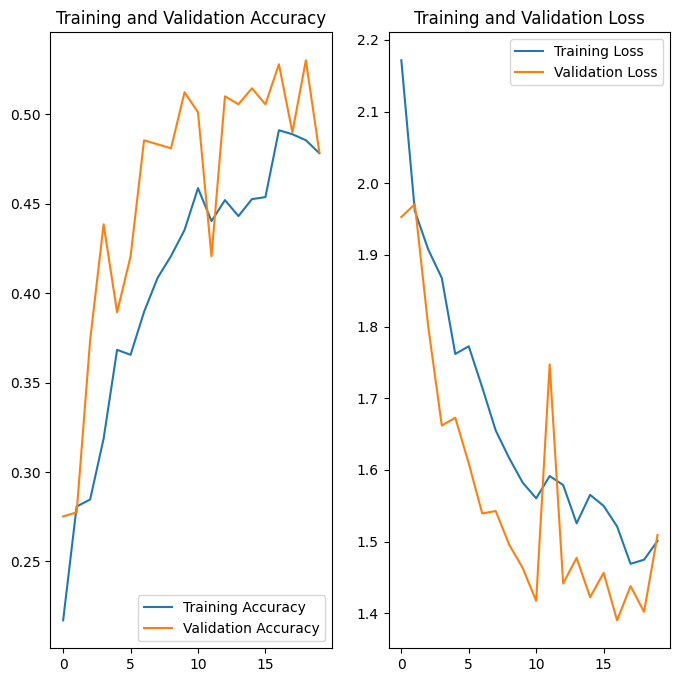

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
Training Accuracy and Validation Accuracy:

- The training accuracy steadily increases and reaches approximately 0.5 by the end of training.
- The validation accuracy closely follows the training accuracy, reaching around 0.5, with no significant divergence between the two curves. This indicates improved generalization compared to the previous model.

Training Loss and Validation Loss:

- Both training and validation loss decrease steadily over the epochs.
The training loss reduces from ~2.2 to ~1.5, while the validation loss decreases from ~2 to ~1.5 by the end of training.
- The validation loss does not exhibit a significant increase or divergence from the training loss, suggesting reduced overfitting compared to the earlier results.

The addition of the augmentation layer and the drop out layer appears to have improved the model's generalization ability. The training and validation metrics are closely aligned, indicating that the model is no longer overfitting to the training data

### The validation accuracy is still low at around 50% indicating that there can be a class imbalance due to which the model is not able to learn all the classes. We need to build another model after fixing the class imbalance

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
import numpy as np

# Get all the labels from the training dataset
labels = np.concatenate([y for x, y in train_ds], axis=0)

# Count the occurrences of each class
class_counts = np.bincount(labels)

# Get the unique class labels (assuming they are integers starting from 0)
class_labels = np.unique(labels)

# Print the distribution
for label, count in zip(class_labels, class_counts):
    print(f"Class {label}: {count} samples")

# Optional: Print percentages
total_samples = len(labels)
for label, count in zip(class_labels, class_counts):
    percentage = (count / total_samples) * 100
    print(f"Class {label}: {percentage:.2f}%")

Class 0: 92 samples
Class 1: 309 samples
Class 2: 77 samples
Class 3: 352 samples
Class 4: 277 samples
Class 5: 370 samples
Class 6: 58 samples
Class 7: 142 samples
Class 8: 115 samples
Class 0: 5.13%
Class 1: 17.24%
Class 2: 4.30%
Class 3: 19.64%
Class 4: 15.46%
Class 5: 20.65%
Class 6: 3.24%
Class 7: 7.92%
Class 8: 6.42%


#### - Which class has the least number of samples?
 - Class 6 has the least with just 3.24% of the total number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
-  Class 5 has the highest with 20.65% of the total number of samples


In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="/content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BAA081DBB20>: 100%|██████████| 500/500 [00:26<00:00, 18.74 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAA8823EFE0>: 100%|██████████| 500/500 [00:18<00:00, 26.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BAA08103040>: 100%|██████████| 500/500 [00:20<00:00, 24.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BAA0819AAA0>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2314x2067 at 0x7BAA082C03D0>: 100%|██████████| 500/500 [01:19<00:00,  6.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAA8823C7C0>: 100%|██████████| 500/500 [00:21<00:00, 23.03 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BAA87F80A00>: 100%|██████████| 500/500 [00:38<00:00, 12.93 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAA0807EEF0>: 100%|██████████| 500/500 [00:20<00:00, 24.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BAA082C2EF0>: 100%|██████████| 500/500 [00:19<00:00, 25.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
import glob

In [28]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [30]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
dataframe_dict_new

{'/content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011013.jpg_c5f27d90-e49f-4285-b5a3-3b28b7627749.jpg': 'seborrheic keratosis',
 '/content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_94207b8f-4f0d-459b-86b5-ffef9e28a279.jpg': 'seborrheic keratosis',
 '/content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_1ff2b25b-d3d2-40dc-95c0-cbec6e2d7833.jpg': 'seborrheic keratosis',
 '/content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_1401f0d2-b80d-4068-9c2c-8590a16d7021.jpg': 'seborrheic keratosis',
 '/content/drive/MyDrive/Melanoma detection assignment/Dataset/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_4c1da1e7-c5c

In [32]:
# Exclude 'output' folders using negative lookahead assertion
path_list_original = [
    x
    for x in glob.glob(os.path.join(data_dir_train, "*", "*.jpg"))
    if "output" not in x  # Exclude paths containing 'output'
]
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in path_list_original]

# Create the 'original_df' DataFrame
original_df = pd.DataFrame(
    list(zip(path_list_original, lesion_list_original)), columns=["Path", "Label"]
)


df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [33]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

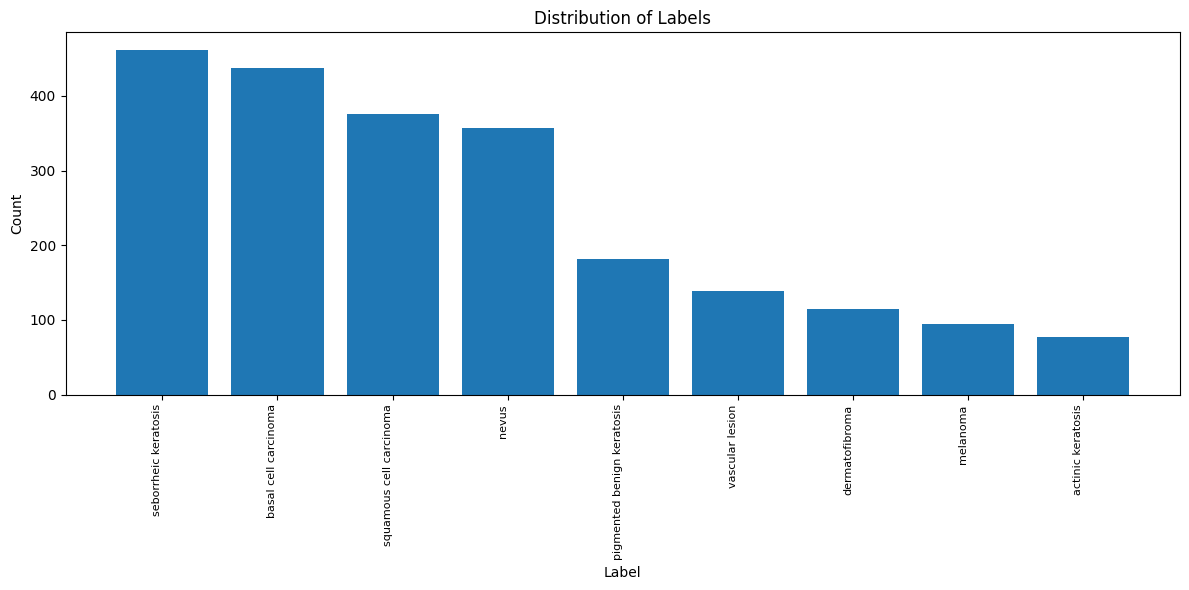

In [46]:
# old distribution
import matplotlib.pyplot as plt

# Get the unique labels and their counts
labels = original_df['Label'].unique()
heights = original_df['Label'].value_counts()

# Create the bar plot with adjusted figure size and font size
plt.figure(figsize=(12, 6))  # Increase figure width
plt.bar(labels, heights)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")

plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate and reduce font size

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

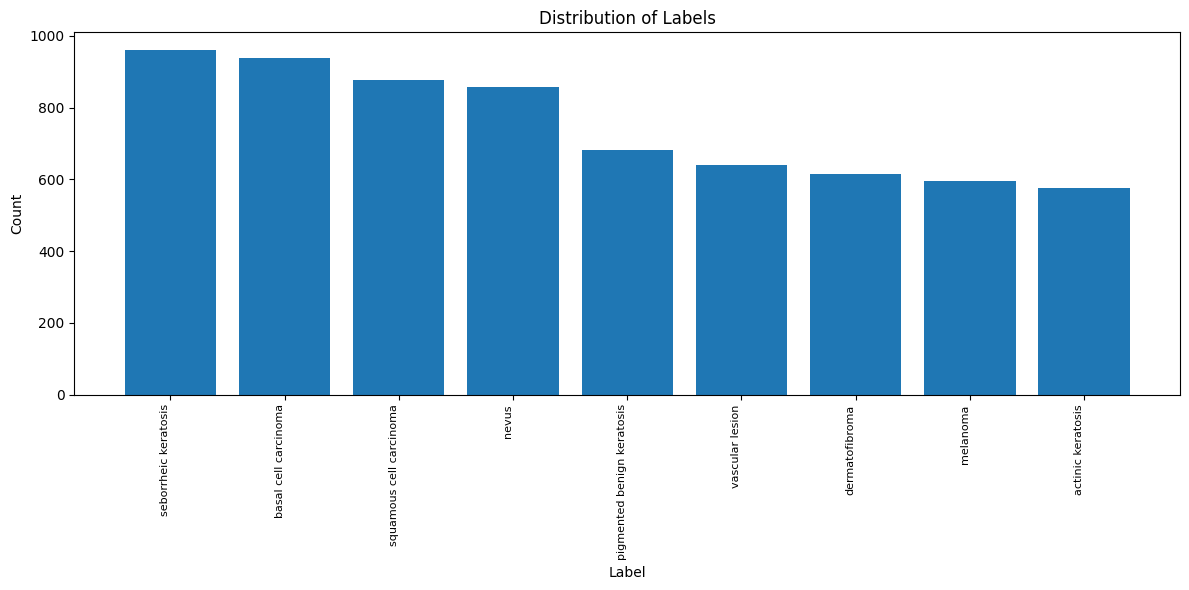

In [47]:
# new distribution after augmentation
import matplotlib.pyplot as plt

# Get the unique labels and their counts
labels = new_df['Label'].unique()
heights = new_df['Label'].value_counts()

# Create the bar plot with adjusted figure size and font size
plt.figure(figsize=(12, 6))  # Increase figure width
plt.bar(labels, heights)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")

plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate and reduce font size

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",  # This is the training subset
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",  # This is the validation subset
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model

In [37]:
from tensorflow.keras.layers import Dropout

model = models.Sequential()

model.add(Rescaling(1./255, input_shape=(img_height, img_height, 3)))
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_height,img_height,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(64,activation='relu'))

# Dropout is most commonly used after Dense (fully connected) layers in CNNs,
# particularly those towards the end of the network.
# This is because Dense layers are more prone to overfitting due to their high number of parameters
# Add a Dropout layer with a dropout rate of 0.2
# (50% of neurons will be dropped out during training)
model.add(Dropout(0.5))

model.add(Dense(len(class_names),activation='softmax'))




/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compile your model (Choose optimizer and loss function appropriately)

In [38]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 215168)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │      13,770,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,864,649 (52.89 MB)

 Trainable params: 13,864,649 (52.89 MB)

 Non-trainable params: 0 (0.00 B)

#### Train your model

In [40]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 260ms/step - accuracy: 0.1829 - loss: 2.4685 - val_accuracy: 0.3519 - val_loss: 1.7199
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 239ms/step - accuracy: 0.3272 - loss: 1.8011 - val_accuracy: 0.4365 - val_loss: 1.4517
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - accuracy: 0.3966 - loss: 1.5972 - val_accuracy: 0.4796 - val_loss: 1.3540
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step - accuracy: 0.4353 - loss: 1.5000 - val_accuracy: 0.5078 - val_loss: 1.2918
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.4413 - loss: 1.4555 - val_accuracy: 0.5189 - val_loss: 1.2502
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 238ms/step - accuracy: 0.4877 - loss: 1.3249 - val_accuracy: 0.5390 - val_loss: 1.1992
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.5177 - loss: 1.2640 - val_accuracy: 0.5509 - val_loss: 1.1788
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - accuracy: 0.5182 - loss: 1

#### Visualize the model results

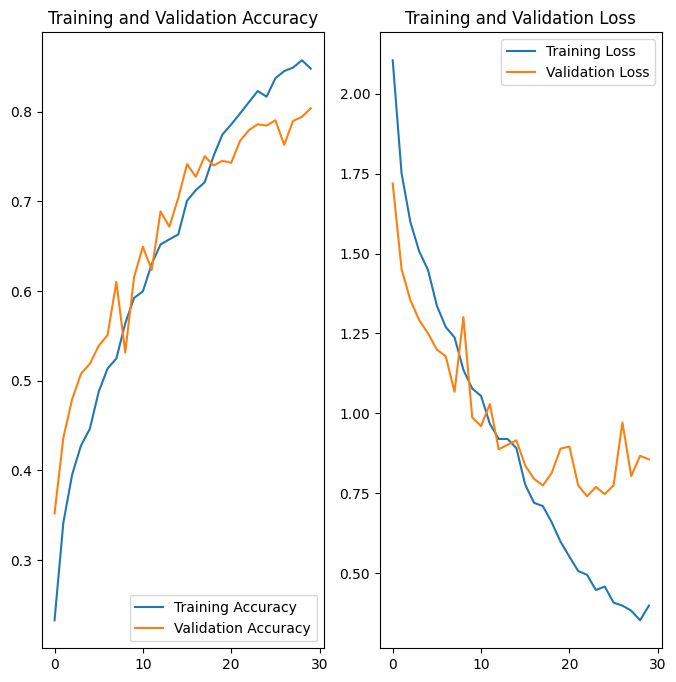

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:

Training Accuracy and Validation Accuracy:

- The training accuracy reaches approximately 0.86 by the end of training, indicating the model is learning the training data well.
- The validation accuracy stabilizes around 0.83, which shows a good improvement compared to earlier results. However, there is still a slight gap between training and validation accuracy.

Training Loss and Validation Loss:

- The training loss steadily decreases to approximately 0.40, showing that the model is fitting the training data effectively.
- The validation loss decreases initially but plateaus and fluctuates around 0.75 after epoch 20, indicating that the model may still struggle slightly to generalize on unseen data.

Class Imbalance Fix:

Adding 500 additional images per class using the Augmentor library appears to have significantly improved the overall model performance. The validation accuracy has increased, and overfitting has been reduced compared to previous results.

